# Image transformer
This notebook aims to replicate the machine learning research paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) (ViT paper) with PyTorch.

# 0. Getting setup

In [383]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine, helper_functions


In [384]:
# If you are not using Apple Silicon Mac (M1, M2, M1 Pro, M1 Max, M1 Ultra, etc).
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device

In [385]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


# 1. Get data

In [386]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create Datasets and DataLoaders
In Table 3 in the ViT paper, the training resolution is mentioned as being 224 (height=224, width=224). Therefore a corresponding transform will be applied to the data.

## 2.1 Prepare transforms for images

In [387]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


## 2.2 Turn images into `DataLoader`'s
The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32). We will keep using a batch size of 32 due to hardware limitations. 

In [388]:
# Set the batch size
BATCH_SIZE = 32 # Lower than the ViT paper (4096) due to hardware limitations

# Creat data loader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2b4a3f430>,
 ['pizza', 'steak', 'sushi'])

## 2.3 Visualizing a single image

In [389]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

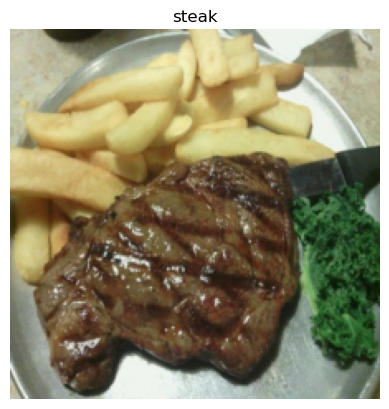

In [390]:
# Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

## 3. Equation 1: Split data into patches and creating the class, position and patch embedding

## 3.1 Calculating patch embedding input and output shapes

In [391]:
# Creat example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [392]:
# Input shape (this is the size of a singe image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## 3.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

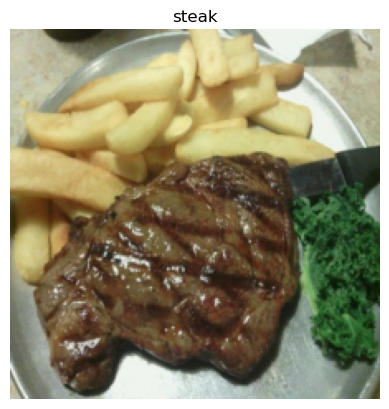

In [393]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

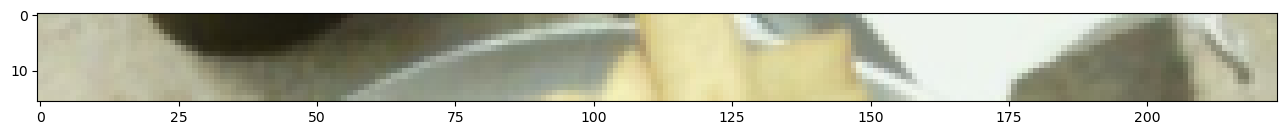

In [394]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pizels x 16 pixels


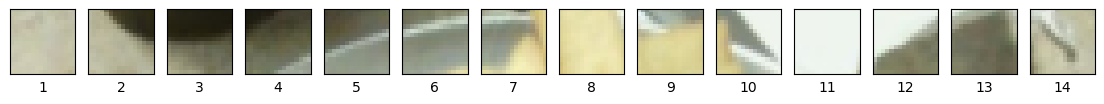

In [395]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pizels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # One column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]) # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


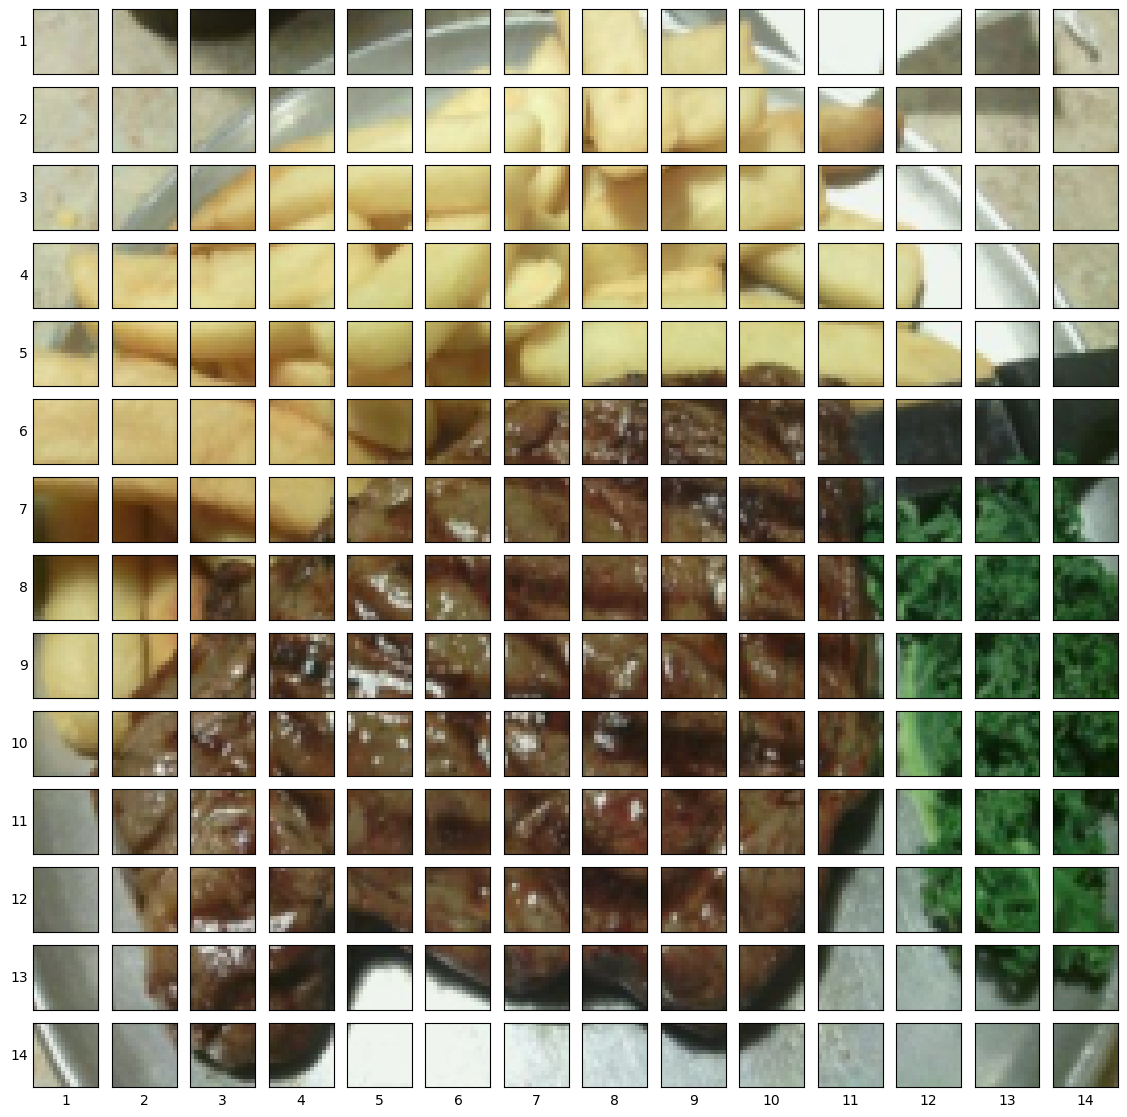

In [396]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fix, axs = plt.subplots(nrows=img_size // patch_size, # Need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
# Set a super title
fig.suptitle(f"{class_names[label]} --> Patchified", fontsize=16)
plt.show()

## Creating image patches with `torch.nn.Conv2d()`

In [397]:
from torch import nn

# Set the patch size
patch_size = 16

# The Conv2d layer with hyperparameters form the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # Same as (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

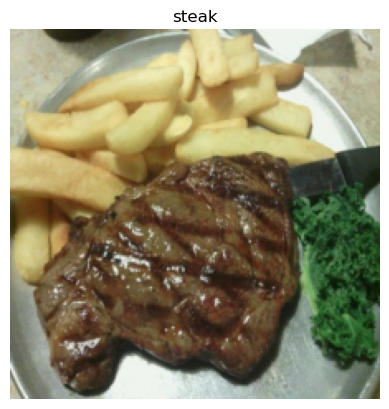

In [398]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [399]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [429, 648, 139, 572, 447]


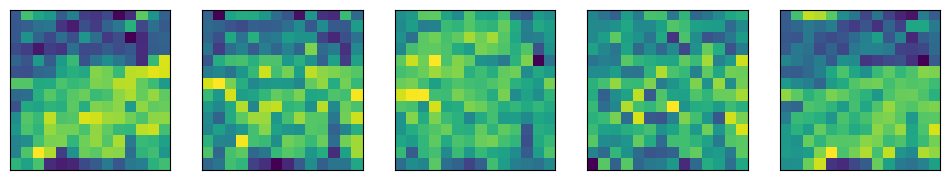

In [400]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [401]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.8030, -0.5488, -0.2053, -0.2710, -0.4413, -0.6469, -0.7310,
           -0.9320, -0.9164, -0.8041, -1.0252, -0.7599, -0.4574, -0.8030],
          [-0.8038, -0.7616, -0.7411, -0.7673, -0.7650, -0.9403, -0.8635,
           -0.9650, -0.8220, -0.7965, -0.6306, -0.7146, -0.5300, -0.6620],
          [-0.8657, -0.6454, -0.6857, -0.8317, -0.7739, -0.8243, -0.5628,
           -0.6008, -0.6946, -0.7913, -0.9470, -0.9561, -0.7822, -0.7096],
          [-0.8422, -0.8350, -0.8682, -0.8365, -0.9456, -0.7241, -0.8172,
           -0.7590, -0.6870, -0.7414, -0.8712, -0.8102, -0.8911, -0.7323],
          [-0.6928, -0.6157, -0.6361, -0.7583, -0.6662, -0.4601, -0.6777,
           -0.7995, -0.7407, -0.7370, -0.8049, -0.7574, -0.7281, -0.5547],
          [-0.7739, -0.7770, -0.7485, -0.7118, -0.4387, -0.3615, -0.3250,
           -0.3744, -0.3329, -0.2335, -0.1559, -0.1346, -0.1425, -0.1008],
          [-0.3367, -0.3102, -0.5817, -0.6721, -0.4170, -0.4498, -0.3554,
           -0.3240, -0.3629, -0.

## 3.4 Flattening the patch embedding with `torch.nn.Flatten()`

In [402]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [403]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


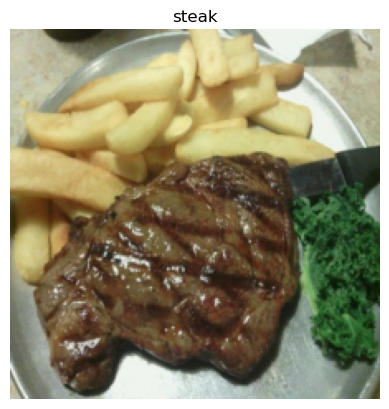

In [404]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [405]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

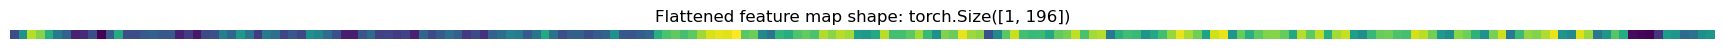

In [406]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [407]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.8030, -0.5488, -0.2053, -0.2710, -0.4413, -0.6469, -0.7310, -0.9320,
          -0.9164, -0.8041, -1.0252, -0.7599, -0.4574, -0.8030, -0.8038, -0.7616,
          -0.7411, -0.7673, -0.7650, -0.9403, -0.8635, -0.9650, -0.8220, -0.7965,
          -0.6306, -0.7146, -0.5300, -0.6620, -0.8657, -0.6454, -0.6857, -0.8317,
          -0.7739, -0.8243, -0.5628, -0.6008, -0.6946, -0.7913, -0.9470, -0.9561,
          -0.7822, -0.7096, -0.8422, -0.8350, -0.8682, -0.8365, -0.9456, -0.7241,
          -0.8172, -0.7590, -0.6870, -0.7414, -0.8712, -0.8102, -0.8911, -0.7323,
          -0.6928, -0.6157, -0.6361, -0.7583, -0.6662, -0.4601, -0.6777, -0.7995,
          -0.7407, -0.7370, -0.8049, -0.7574, -0.7281, -0.5547, -0.7739, -0.7770,
          -0.7485, -0.7118, -0.4387, -0.3615, -0.3250, -0.3744, -0.3329, -0.2335,
          -0.1559, -0.1346, -0.1425, -0.1008, -0.3367, -0.3102, -0.5817, -0.6721,
          -0.4170, -0.4498, -0.3554, -0.3240, -0.3629, -0.2109, -0.2633, -0.1986,
          -0.227

## 3.5 Turning the ViT patch embedding layer into a PyTorch module

In [408]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__ (self,
                  in_channels: int=3,
                  patch_size: int=16,
                  embedding_dim: int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1).to(device) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [409]:
from going_modular.utils import set_seeds
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding()

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")
patch_embedded_image.dtype

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


torch.float32

In [410]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # swap this for "random_input_image_error"  to see error
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 3.6 Creating the class token embedding

In [411]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-7.6375e-01,  1.8706e-01, -2.3238e-01,  ...,  5.9451e-01,
          -3.4154e-01,  2.9928e-01],
         [-5.1671e-01, -3.5750e-02, -3.5242e-01,  ...,  4.3029e-01,
          -1.5548e-01,  3.3149e-01],
         [-2.3227e-01,  2.0287e-02, -2.9024e-01,  ...,  2.4354e-01,
           9.6744e-05,  2.4851e-01],
         ...,
         [-6.8072e-01,  1.7487e-01, -2.0243e-01,  ...,  5.3366e-01,
          -2.9990e-01,  2.3801e-01],
         [-5.1162e-01,  1.0012e-01, -1.9854e-01,  ...,  4.1067e-01,
          -2.2778e-01,  2.8188e-01],
         [-4.1108e-01,  6.8832e-02, -1.4271e-01,  ...,  3.5986e-01,
          -2.2986e-01,  7.7731e-02]]], device='mps:0',
       grad_fn=<ToCopyBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [412]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True).to(device) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], device='mps:0',
       grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [413]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.7637,  0.1871, -0.2324,  ...,  0.5945, -0.3415,  0.2993],
         [-0.5167, -0.0358, -0.3524,  ...,  0.4303, -0.1555,  0.3315],
         ...,
         [-0.6807,  0.1749, -0.2024,  ...,  0.5337, -0.2999,  0.2380],
         [-0.5116,  0.1001, -0.1985,  ...,  0.4107, -0.2278,  0.2819],
         [-0.4111,  0.0688, -0.1427,  ...,  0.3599, -0.2299,  0.0777]]],
       device='mps:0', grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## 4.7 Creating the position embedding

In [414]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.7637,  0.1871, -0.2324,  ...,  0.5945, -0.3415,  0.2993],
          [-0.5167, -0.0358, -0.3524,  ...,  0.4303, -0.1555,  0.3315],
          ...,
          [-0.6807,  0.1749, -0.2024,  ...,  0.5337, -0.2999,  0.2380],
          [-0.5116,  0.1001, -0.1985,  ...,  0.4107, -0.2278,  0.2819],
          [-0.4111,  0.0688, -0.1427,  ...,  0.3599, -0.2299,  0.0777]]],
        device='mps:0', grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [415]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D positional embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True).to(device)

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], device='mps:0',
       grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [416]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.2363, 1.1871, 0.7676,  ..., 1.5945, 0.6585, 1.2993],
         [0.4833, 0.9642, 0.6476,  ..., 1.4303, 0.8445, 1.3315],
         ...,
         [0.3193, 1.1749, 0.7976,  ..., 1.5337, 0.7001, 1.2380],
         [0.4884, 1.1001, 0.8015,  ..., 1.4107, 0.7722, 1.2819],
         [0.5889, 1.0688, 0.8573,  ..., 1.3599, 0.7701, 1.0777]]],
       device='mps:0', grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## 3.8 Putting it all together: from image to embedding

In [417]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding()

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True).to(device)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True).to(device)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}") 


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 4. Equation 2: Multi-Head Attention (MSA)

In [418]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim: int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads: int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout: float=0): # doesn't look like the paper uses any dropout in MSA-blocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    # 5. Create a forward method to pass he data through the layers
    def forward(self, x):
        x.to(device)
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # Query embeddings,
                                                key=x, # Key embeddings
                                                value=x, # Value embeddings
                                                need_weights=False) # We just need the weights, not the layer outputs
        return attn_output

In [419]:
# Create an instance of the MSA-block
multihead_self_attention_block = MultiheadSelfAttentionBlock().to(device)

# Pass patch and position image embedding through the MSA-block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}") # The shapes stays the same but the data in the tensors changes

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 5. Equation 3: Multilayer perceptron (MLP)

In [420]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """
    Creates a layer normalized multilayer perceptron block ("MLP block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
               embedding_dim: int=768, # Hidden Size D from Table 1 for ViT-Base
               mlp_size: int=3072, # MLP size from Table 1 for ViT-Base
               dropout: float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [421]:
# Create an instance of MLPBlock
mlp_block = MLPBlock().to(device)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 6. Create the transformer encoder

In [422]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 mlp_dropout: float=0.1,
                 attn_dropout: float=0):
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        # 4. Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
    # 5. Define a forward method
    def forward(self, x):
        # 6. Create residual connection for MSA block
        x = self.msa_block(x) + x

        # 7. Create residual connection for MLP block
        x = self.mlp_block(x) + x

        return x

In [423]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## 6.2 Creating a transformer encoder with PyTorch's transformer layers

In [424]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True) # Normalize first or after MSA/MLP layers
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [425]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# 7. Putting it all together to create ViT

In [426]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attn_dropout: float=0,
                 mlp_dropout: float=0.1,
                 embedding_dropout: float=0.1,
                 num_classes: int=1000): # Default for ImageNet but can customize this
        super().__init__()

        # 3. Make sure that the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width / patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
                

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        
        # 10. Create classifier head
        self.classfier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    
    # 11. Create a forward method
    def forward(self, x):
        x.to(device)
        # 12. Get batch size
        batch_size = x.shape[0]
  
        # 13. Create class token embeddings and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1).to(device) # "-1" means to infer the dimension (try this line on its own)
        # 14. Create patch embedding
        x = self.patch_embedding(x)
    
        # 15. Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1).to(device)
    
        # 16. Add position embedding to patch embedding
        x = self.position_embedding + x
    
        # 17. Run embedding dropout
        x = self.embedding_dropout(x)
    
        # 18. Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)
     
        # 19. Put 0 index logit through classifier
        x = self.classfier(x[:, 0]) # Run on each sample in a batch at 0 index
  
        return x        

In [427]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [428]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224).to(device) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names)).to(device)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.0755, 0.6951, 1.1550]], device='mps:0', grad_fn=<LinearBackward0>)

In [429]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device="mps"
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# 8. Setting up training code for the ViT model

In [430]:
from going_modular import engine

# Setup the optimzer
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)
# Setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8880 | train_acc: 0.3208 | test_loss: 1.9695 | test_acc: 0.3074
Epoch: 2 | train_loss: 1.2076 | train_acc: 0.3625 | test_loss: 1.3580 | test_acc: 0.3131
Epoch: 3 | train_loss: 1.1800 | train_acc: 0.3479 | test_loss: 1.1491 | test_acc: 0.2989
Epoch: 4 | train_loss: 1.1256 | train_acc: 0.2812 | test_loss: 1.2084 | test_acc: 0.3159
Epoch: 5 | train_loss: 1.1166 | train_acc: 0.3563 | test_loss: 1.1285 | test_acc: 0.3824
Epoch: 6 | train_loss: 1.1386 | train_acc: 0.3146 | test_loss: 1.2408 | test_acc: 0.3045
Epoch: 7 | train_loss: 1.1320 | train_acc: 0.3729 | test_loss: 1.1540 | test_acc: 0.3131
Epoch: 8 | train_loss: 1.1322 | train_acc: 0.3104 | test_loss: 1.0952 | test_acc: 0.3881
Epoch: 9 | train_loss: 1.1385 | train_acc: 0.3521 | test_loss: 1.1110 | test_acc: 0.3852
Epoch: 10 | train_loss: 1.1389 | train_acc: 0.3438 | test_loss: 1.1306 | test_acc: 0.3102


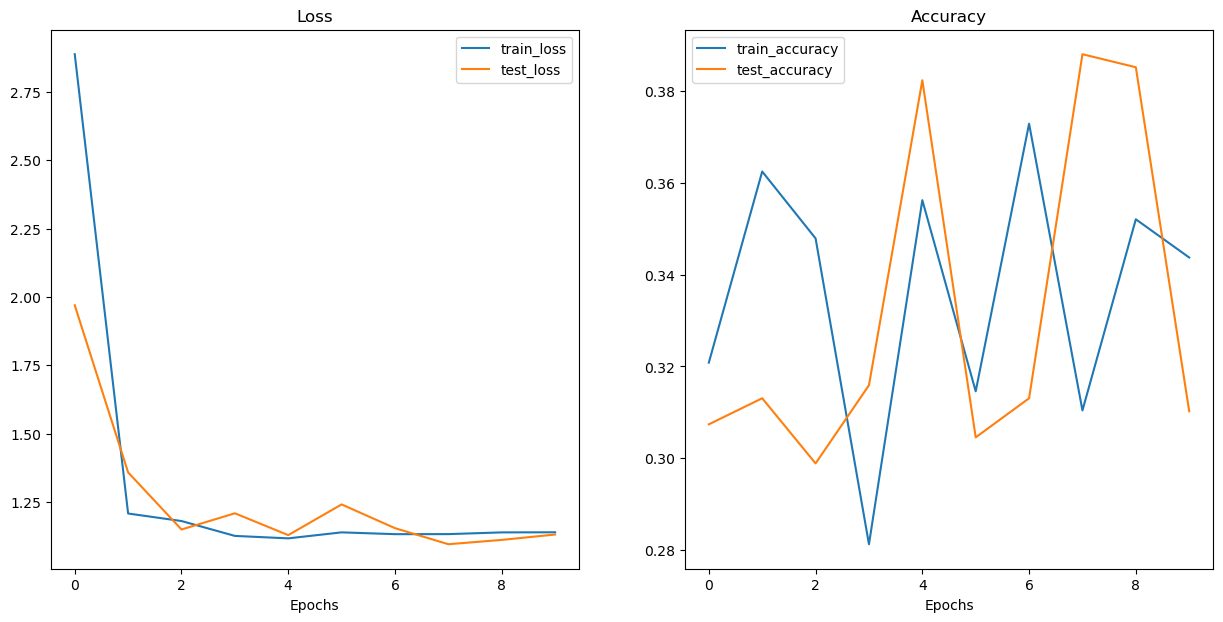

In [432]:
from going_modular.helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# 9. Using a pretrained ViT from `torchvision.models` on the same dataset

In [433]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

2.0.1
0.15.2


In [469]:
# 1. Get pretrained weights for ViT-base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    parameter.to(device)

# 4. Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [476]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [475]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [473]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [477]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2613 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.2196 | train_acc: 0.9458 | test_loss: 0.1490 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.1533 | train_acc: 0.9583 | test_loss: 0.1125 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1306 | train_acc: 0.9604 | test_loss: 0.0959 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1081 | train_acc: 0.9688 | test_loss: 0.0819 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.0986 | train_acc: 0.9771 | test_loss: 0.0770 | test_acc: 0.9812
Epoch: 7 | train_loss: 0.0914 | train_acc: 0.9812 | test_loss: 0.0725 | test_acc: 0.9847
Epoch: 8 | train_loss: 0.0732 | train_acc: 0.9854 | test_loss: 0.0642 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0649 | train_acc: 0.9854 | test_loss: 0.0601 | test_acc: 0.9812
Epoch: 10 | train_loss: 0.0560 | train_acc: 0.9875 | test_loss: 0.0608 | test_acc: 0.9750


In [479]:
device # Got error when running pretrained model on mps

'cpu'